In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
import pandas as pd

In [3]:
images_path = '../data/resized_and_user_images'
labels_path = '../data/resized_and_user_labels.csv'

In [4]:
y = pd.read_csv(labels_path, index_col='filename')

def get_y_func(x):
    filename = str(x).split('/')[-1]
    zipped = zip(list(y.loc[filename])[0::2], list(y.loc[filename])[1::2])
    return tensor(list(zipped))

In [5]:
dblock = DataBlock(
    get_items=get_image_files,
    blocks=(ImageBlock, PointBlock),
    splitter=RandomSplitter(valid_pct=0.15),
    get_y=get_y_func,
    batch_tfms=[
        *aug_transforms(
            do_flip=False,
            size=(160,160), 
            max_rotate=15,
            max_lighting=0.5,
            max_warp=0.4
        ),
        Normalize.from_stats(*imagenet_stats)
    ]
)

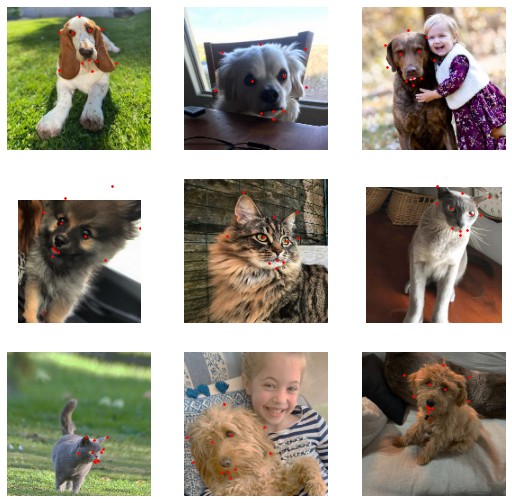

In [6]:
dls = dblock.dataloaders(images_path, bs=32)
dls.c = dls.train.after_item.c
dls.show_batch()

In [7]:
learn = cnn_learner(
    dls, 
    resnet18, 
    loss_func=MSELossFlat(), 
    opt_func=ranger
).to_fp16() # clip=0.1

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [8]:
learn.freeze_to(-1)

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.17378008365631104)

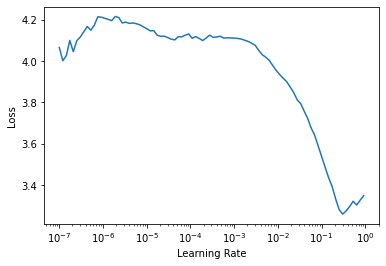

In [9]:
learn.lr_find()

In [10]:
learn.fit_flat_cos(
    5, 
    5e-2
)

epoch,train_loss,valid_loss,time
0,0.071868,0.071556,01:49
1,0.080528,0.075145,01:48
2,0.073500,0.047543,01:49
3,0.070764,0.048739,01:49
4,0.047752,0.032171,01:48


In [12]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=0.00010964782268274575)

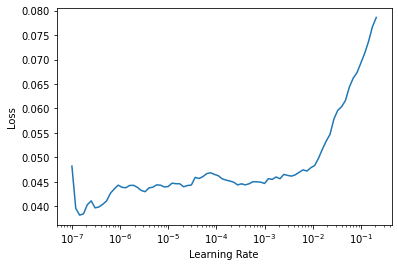

In [13]:
learn.lr_find()

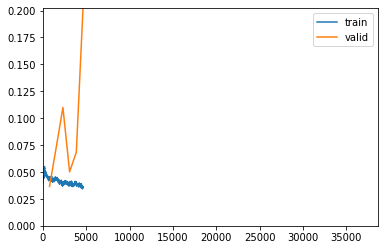

IndexError: list index out of range

In [15]:
learn.fit_flat_cos(
    50, 
    5e-5, 
    wd=0.1,
    cbs=[
        SaveModelCallback(), 
        ShowGraphCallback(),
        CSVLogger()
    ]
)

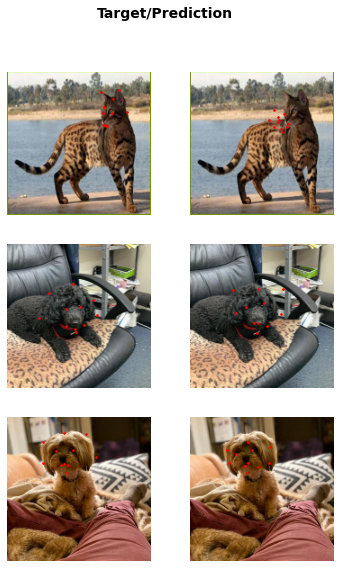

In [11]:
learn.show_results()

In [44]:
learn.export('../models/export.pkl')

In [46]:
### Deployement

In [45]:
learn = load_learner('../models/export.pkl')

In [ ]:
%%writefile pet_regression.py
from bentoml import BentoService, api, env, artifacts 
from bentoml.artifact import Fastai2ModelArtifact
from bentoml.handlers import FastaiImageHandler

@env(pip_dependencies=['gevent', 'fastai'])
@artifacts([Fastai2ModelArtifact('pet_regressor')])
class PetRegression(BentoService):
    
    @api(FastaiImageHandler)
    def predict(self, image):
        result = self.artifacts.pet_regressor.predict(image)
        return result[2].tolist()